In [1]:
# Peter Karras 2020
''' Contains the Custom Dataset creation and the CNN
    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'''

' Contains the Custom Dataset creation and the CNN\n    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'

In [1]:
""" IMPORT NEEDED MODULES """

import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import time


import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models


import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets

In [2]:
# Issues with directories, use this to reset cwd and then move into desired directory 
#os.chdir("/content")
startingDir = os.getcwd()
print(startingDir)

C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2


In [3]:
""" CREATE CUSTOM DATASET """
# Pulls from pool of 900 thermal images
class BCIDataset2(Dataset):
    def __init__(self, csv_master_path, transform=None):
        """
        Args:
            csv_master_path (string): path to csv file with thermal image (csv's) file paths
            as first column and GPP values as the second column, rows are one set of
            correlating data points
            transform (callable, optional): Optional transform to be applied on a sample
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file 
        #self.data_info = pd.read_csv(csv_master_path, header=None)
        self.data_info = pd.read_csv(csv_master_path)
        # First column contains thermal image (csv's) file paths
        self.thermal_path_arr = np.asarray(self.data_info.iloc[:,0])
        # Second column is the GPP values for the images from first column
        self.GPP_arr = np.asarray(self.data_info.iloc[:,1])        
        self.transform = transforms.ToTensor()
        max_list = np.full(1,-10)
        min_list = np.full(1, 99999)
        csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata2503"
        os.chdir(csvfilesMLLocation)
        start = time.time()
#         for filename in self.thermal_path_arr:
#             file_temps = pd.read_csv(filename)
#             file_temps_vals = file_temps.values
#             torch_temps = torch.from_numpy(file_temps_vals)
#             max_list = np.append(max_list, [torch.max(torch_temps)])
#             min_list = np.append(min_list, [torch.min(torch_temps)])
#         self.ABS_MAX = (torch.max(torch.from_numpy(max_list))).item()
#         self.ABS_MIN = (torch.min(torch.from_numpy(min_list))).item()
        self.ABS_MAX = 40.508388402478
        self.ABS_MIN = 24.8413349715329
        print(f'Time: {time.time()-start}')
        print("max is:", self.ABS_MAX)
        print("max is:", self.ABS_MIN)
            
        
    #NOTE: might need to flip image
    def __getitem__(self, index):
        # Get thermal image (csv) path
        single_thermal_path = self.thermal_path_arr[index]
        # Convert csv to pandas dataframe
        pd_thermal_img = pd.read_csv(single_thermal_path)
        # Convert pandas dataframe to numpy array
        ###np_thermal_img = np.asarray(pd_thermal_img.iloc[:,1:])
        np_thermal_img = np.asarray(pd_thermal_img)
        # Normalization of values from orignal csv file, translates thermal values to 0-1 range
        # https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range
        np_normalized_temp_no_channel = ((np_thermal_img-self.ABS_MIN)/(self.ABS_MAX - self.ABS_MIN))
        # Flip image by 90 degrees, is commented out currently as might mess with network architecture
        #np_thermal_img = np.rot90(np_thermal_img)
        # Add num channels dimension and format correctly
        np_normalized_temp = np.expand_dims(np_normalized_temp_no_channel, axis=0)
        # Transform numpy array to tensor
        tensor_normal_thermal_vals = torch.from_numpy(np_normalized_temp)
        # Get GPP value for image
        single_image_GPP = self.GPP_arr[index]
        return(tensor_normal_thermal_vals, single_image_GPP)
    
    def __len__(self):
        return len(self.data_info)

In [4]:
""" LOAD IN DATA """
os.chdir(startingDir)
# Number of subprocesses to use for data loading 
num_workers = 0
# How many samples per batch to load
batch_size = 3
# Proportion of training set to use for validation and testing
# Note: this will be split in equal halves, one for validation, one for testing
valid_and_test_proportion = 0.3


# Define transforms
transformations = transforms.Compose([transforms.ToTensor()])
# Define custom datasets, for training and for testing
# Note: Will be using 10,000 data for testing, 50,000 data for training in future
masterfileMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata2503/populatedGPPs.csv"
BCIDataset = BCIDataset2(masterfileMLLocation)

# Obtain indices for training, validation and testing datasets
num_train = len(BCIDataset)         # Number of data points (csv files to be used)
indices1 = list(range(num_train))   # indices of [0,num_train) to represent data
np.random.shuffle(indices1)         # Shuffled indices
# Splitting training from validation/testing
split1 = int(np.floor(valid_and_test_proportion * num_train))

train_indices, valid_and_test_indices = indices1[split1:], indices1[:split1]
# Splitting validation/testing up into their individual groups
num_valid_test = len(valid_and_test_indices)

split2 = int(np.floor(0.5 * num_valid_test))
valid_indices, test_indices = valid_and_test_indices[split2:], valid_and_test_indices[:split2]
# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Prepare data loaders 
train_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=test_sampler, num_workers=num_workers, pin_memory=True)

#Time: 401.0922603607178s for 10,000 files
#max is: 43.8977567043499
#max is: 22.0574247607658
# Time: 153.2100191116333 for 4,000 files
# max is: 40.046902918943
# max is: 22.0574247607658
# Time: 91.14127731323242 for 2,503 files
#max is: 40.508388402478
#max is: 24.8413349715329

Time: 0.0
max is: 40.508388402478
max is: 24.8413349715329


torch.Size([3, 1, 320, 240])
tensor(33.8957)
tensor(33)
(1, 320, 240)
tensor(32.2149)
tensor(32)
(1, 320, 240)
tensor(0.)
tensor(0)
(1, 320, 240)


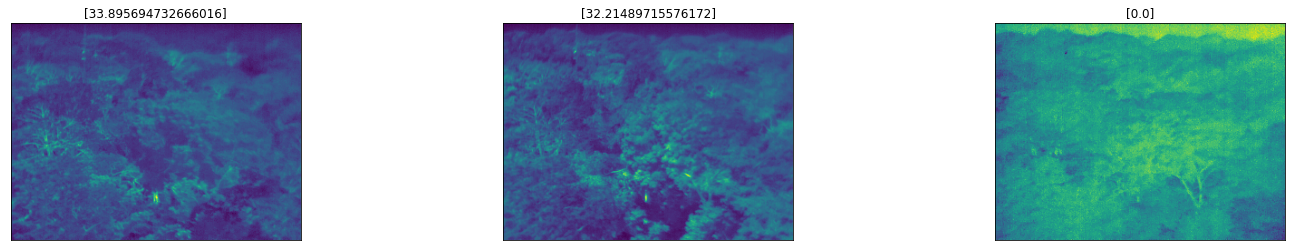

In [7]:
""" VISUALIZE A BATCH OF THE DATA 
    Taken straight from dataloader """
os.chdir(startingDir)
csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata2503"
os.chdir(csvfilesMLLocation)

import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    plt.imshow(np.rot90(np.squeeze(img)))
    
# Obtain one batch of training images
dataiter = iter(train_loader)
type(dataiter)
images, labels = dataiter.next()
print(images.shape)
images = images.numpy() # convert images to numpy for display
#print(images)

    # print(images[1].shape)
    # imgtoshow = Image.fromarray(images[1], 'L')
    # imgtoshow.show()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# Display 3 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    print(labels[idx])
    print(labels[idx].long())
    ax.set_title([labels[idx].item()])
    # Save Images for inspection
    print(images[idx].shape)
os.chdir(startingDir)

In [2]:
"""Working network"""
class BCIModel(nn.Module):
    def __init__(self):
        super(BCIModel, self).__init__()
        # Convulutional Layer 1 (sees 320 x 240 x 1 image tensor)
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        # Convulutional Layer 2 (sees 160 x 120 x 16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        # Convulutional Layer 3 (sees 80 x 60 x 32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        # Convulutional Layer 4 (sees 40 x 30 x 64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # Linear and Batchnorm Layers
        self.fc1 = nn.Linear(128 * 20 * 15, 100)
        self.BatchN = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 1)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Add sequence of convulutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 20 * 15)
        # Add dropout layer
        x = self.dropout(x)
        # Add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add last layer
        x = (self.fc2(x))
        return x

In [11]:
# GET NEW MODEL IMPORTED HEREEEEEEEEEEEEEEE
#resnet18
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Peter/.cache\torch\checkpoints\resnet18-5c106cde.pth


In [9]:
#print(resnet)
transform = transforms.Compose([            #[1]
    transforms.Resize(256),                    #[2]
    transforms.CenterCrop(224),                #[3]
    transforms.ToTensor(),                     #[4]
    transforms.Normalize(                      #[5]
        mean=[0.485, 0.456, 0.406],                #[6]
        std=[0.229, 0.224, 0.225]                  #[7]
 )])

In [3]:
#raise Exception("Not currently creating new model")
# Defining the model
model = BCIModel()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr =0.001)
# defining the scheduler, to handle learning rate changes
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
# defining loss function
criterion = nn.MSELoss()
print(model)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()

BCIModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=38400, out_features=100, bias=True)
  (BatchN): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
CUDA is available!  Training on GPU ...


In [4]:
from torchsummary import summary
summary(modelBCI, (1,320,240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 320, 240]             160
         MaxPool2d-2         [-1, 16, 160, 120]               0
            Conv2d-3         [-1, 32, 160, 120]           4,640
         MaxPool2d-4           [-1, 32, 80, 60]               0
            Conv2d-5           [-1, 64, 80, 60]          18,496
         MaxPool2d-6           [-1, 64, 40, 30]               0
            Conv2d-7          [-1, 128, 40, 30]          73,856
         MaxPool2d-8          [-1, 128, 20, 15]               0
           Dropout-9                [-1, 38400]               0
           Linear-10                  [-1, 100]       3,840,100
          Dropout-11                  [-1, 100]               0
           Linear-12                    [-1, 1]             101
Total params: 3,937,353
Trainable params: 3,937,353
Non-trainable params: 0
---------------------------

In [8]:
# Optimization? Best for inputs that do not change in size (this network)
# "This flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware"
torch.backends.cudnn.benchmark = True

# Check that we are on GPU
for p in model.parameters():
    print(p.device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
    
"""
Test new pinned memory speeds
mess with number of workers"""

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


'\nTest new pinned memory speeds\nmess with number of workers'

In [9]:
""" TRAINING OF MODEL """

raise Exception("DO NOT TRAIN, EVALUATION ONLY")
os.chdir(startingDir)
csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata2503"
os.chdir(csvfilesMLLocation)
# Number of epochs to train the model
# try 10, 100, 500, 1000
n_epochs = 80

valid_loss_min = np.Inf    # Track change in validation loss, set 

for epoch in range(1, n_epochs+1):
    print(optimizer.param_groups[0]['lr'])
    # Measurement of epoch times
    start = time.time()
    print("Epoch #:", epoch)
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # Clear the gradients fo all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Fixes shape
        output = torch.flatten(output)
        
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Fixes shape
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # Calculate avearage losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # Print training/validation stats
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_BCI.pt')
        valid_loss_min = valid_loss
    
    # End of time check
    print(f'Time: {time.time()-start}')
    # Step the lr_scheudler 
    if epoch >= 13:
        scheduler.step()
        
print("Operation Complete")

# Epochs for 10,000 files take 280 s per epoch
# Epochs for 4,000 files take 101 s per epoch

0.001
Epoch #: 1
Epoch: 1 	Training Loss: 32.479149 	Validation Loss: 18.438254
Validation loss decreased (inf --> 18.438254).  Saving model ...
Time: 321.99108815193176
0.001
Epoch #: 2
Epoch: 2 	Training Loss: 19.315718 	Validation Loss: 13.332663
Validation loss decreased (18.438254 --> 13.332663).  Saving model ...
Time: 292.05774688720703
0.001
Epoch #: 3
Epoch: 3 	Training Loss: 14.216205 	Validation Loss: 12.387862
Validation loss decreased (13.332663 --> 12.387862).  Saving model ...
Time: 290.67993903160095
0.001
Epoch #: 4
Epoch: 4 	Training Loss: 12.213993 	Validation Loss: 11.615111
Validation loss decreased (12.387862 --> 11.615111).  Saving model ...
Time: 289.8032970428467
0.001
Epoch #: 5
Epoch: 5 	Training Loss: 11.103815 	Validation Loss: 8.429484
Validation loss decreased (11.615111 --> 8.429484).  Saving model ...
Time: 285.5551416873932
0.001
Epoch #: 6
Epoch: 6 	Training Loss: 10.855541 	Validation Loss: 9.946752
Time: 284.94676971435547
0.001
Epoch #: 7
Epoch: 7 

In [11]:
""" TESTING OF MODEL """

# Print out values and images that have large differences in target/value

# Track test loss
test_loss = 0.0
num_predictions = len(test_indices)

# Puts model will notify all your layers that you are in eval mode, that way, 
# batchnorm or dropout layers will work in eval mode instead of training mode.
model.eval()

start = time.time()
counter = 0
# Iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update test loss 
        test_loss += loss.item()*data.size(0)
        
        # Example data tensors
        if counter < 10:
          print("Output of network:\t", output)
          print("Target Values:\t\t", target,"\n")
          counter += 1
        


    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss (mean squared error): {:.6f}\n'.format(test_loss))
print(f'Time: {time.time()-start}')

Output of network:	 tensor([16.7351,  0.1215, 20.5784], device='cuda:0')
Target Values:		 tensor([18.5777,  0.0000, 18.3140], device='cuda:0') 

Output of network:	 tensor([ 0.3322,  1.6057, 15.3320], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.3803, 17.1392], device='cuda:0') 

Output of network:	 tensor([16.2774,  0.3738,  8.1937], device='cuda:0')
Target Values:		 tensor([17.1698,  0.0000, 12.0960], device='cuda:0') 

Output of network:	 tensor([ 0.1175,  0.5438, 16.1475], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000, 17.6768], device='cuda:0') 

Output of network:	 tensor([0.4158, 0.4833, 6.1010], device='cuda:0')
Target Values:		 tensor([0.0000, 0.0000, 6.3552], device='cuda:0') 

Output of network:	 tensor([19.0200,  0.1388, 17.5075], device='cuda:0')
Target Values:		 tensor([18.7513,  0.0000, 16.3634], device='cuda:0') 

Output of network:	 tensor([13.2828,  0.1764, 12.5043], device='cuda:0')
Target Values:		 tensor([10.7945,  0.0000, 11.6508], device='cu